In [1]:
import pandas as pd
import numpy as np
import os
import sys

from sklearn.ensemble import RandomForestClassifier

import librosa
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import train_test_split,cross_val_predict

# to play the audio files
from IPython.display import display, Audio, HTML

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
Ravdess = "audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(Ravdess)
print(ravdess_directory_list)

['Actor_06', 'Actor_04', 'Actor_13', 'Actor_19', 'Actor_18', 'Actor_17', 'Actor_11', 'Actor_10', 'Actor_14', 'Actor_16', 'Actor_09', 'Actor_24', 'Actor_08', 'Actor_03', 'Actor_05', 'Actor_22', 'Actor_02', 'Actor_20', 'Actor_07', 'Actor_15', 'Actor_21', 'Actor_12', 'Actor_23', 'Actor_01']


In [3]:
#ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    print(actor,"->actor")
    for file in actor:
        part = file.split('.')
        print(file,"->file")
        print(part,"-1st split")
        part = part[0].split('-')
        print(part,"-2nd split")
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

    print(file_emotion);print(file_path)

['03-01-03-02-02-02-06.wav', '03-01-07-01-01-02-06.wav', '03-01-02-01-01-02-06.wav', '03-01-08-02-01-01-06.wav', '03-01-04-01-02-02-06.wav', '03-01-04-02-02-01-06.wav', '03-01-04-01-02-01-06.wav', '03-01-01-01-02-01-06.wav', '03-01-02-02-01-01-06.wav', '03-01-05-02-01-01-06.wav', '03-01-07-01-02-01-06.wav', '03-01-02-01-01-01-06.wav', '03-01-04-01-01-02-06.wav', '03-01-08-01-01-01-06.wav', '03-01-07-02-02-01-06.wav', '03-01-05-02-01-02-06.wav', '03-01-06-02-01-02-06.wav', '03-01-05-01-01-02-06.wav', '03-01-08-01-02-01-06.wav', '03-01-01-01-02-02-06.wav', '03-01-01-01-01-01-06.wav', '03-01-02-02-02-01-06.wav', '03-01-06-02-02-01-06.wav', '03-01-05-02-02-02-06.wav', '03-01-03-01-02-01-06.wav', '03-01-06-01-02-01-06.wav', '03-01-07-02-01-01-06.wav', '03-01-05-01-02-01-06.wav', '03-01-08-02-02-02-06.wav', '03-01-02-02-02-02-06.wav', '03-01-06-01-01-02-06.wav', '03-01-07-02-01-02-06.wav', '03-01-03-02-02-01-06.wav', '03-01-07-02-02-02-06.wav', '03-01-04-02-01-01-06.wav', '03-01-02-01-02-01-

In [4]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df],axis=1)

# changing integers to actual emotions.
Ravdess_df['Emotions'].replace([1,2,3,4,5,6,7,8],['neutral','calm','happy','sad','angry','fear','disgust','surprise'], inplace=True)
Ravdess_df.head(10)

,Emotions,Path
0,happy,audio_speech_actors_01-24/Actor_06/03-01-03-02...
1,disgust,audio_speech_actors_01-24/Actor_06/03-01-07-01...
2,calm,audio_speech_actors_01-24/Actor_06/03-01-02-01...
3,surprise,audio_speech_actors_01-24/Actor_06/03-01-08-02...
4,sad,audio_speech_actors_01-24/Actor_06/03-01-04-01...
5,sad,audio_speech_actors_01-24/Actor_06/03-01-04-02...
6,sad,audio_speech_actors_01-24/Actor_06/03-01-04-01...
7,neutral,audio_speech_actors_01-24/Actor_06/03-01-01-01...
8,calm,audio_speech_actors_01-24/Actor_06/03-01-02-02...
9,angry,audio_speech_actors_01-24/Actor_06/03-01-05-02...


In [5]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=int(pitch_factor))

def reverse_audio(data):
    return data[::-1]

def shift_audio(data, shift_max=0.2):
    shift = int(np.random.uniform(-shift_max, shift_max) * len(data))
    return np.roll(data, shift)

def change_volume(data, gain_db=5):
    return data * (10 ** (gain_db / 20.0))

In [6]:
import io
import base64
import matplotlib.pyplot as plt

def plot_waveform(data, sr):
    """Generates a base64-encoded waveform image from audio data."""
    
    # Create a figure and axis with optimized sizing
    fig, ax = plt.subplots(figsize=(3, 1.5))
    ax.plot(data, color='steelblue')
    ax.set_ylim([-1, 1])
    ax.axis('off')  # Remove axis for clean visualization
    plt.tight_layout()

    # Save to an in-memory buffer and encode as base64
    with io.BytesIO() as buf:
        fig.savefig(buf, format='png', dpi=100, bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode('utf-8')
    
    plt.close(fig)  # Explicitly close the figure
    
    return img_str



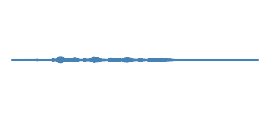
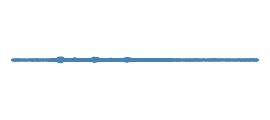
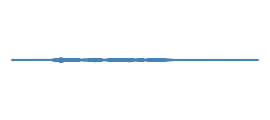
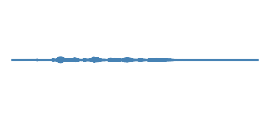
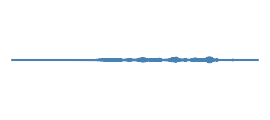
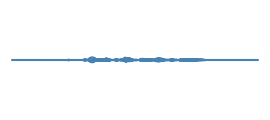
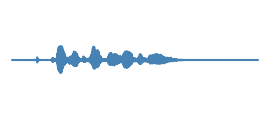

In [7]:
path = 'audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav'
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

# Generate augmented versions
audio_versions = [
    ('Original', data),
    ('Noise', noise(data)),
    ('Stretch', stretch(data)),
    ('Pitch', pitch(data, sample_rate)),
    ('Reverse', reverse_audio(data)),
    ('Shift', shift_audio(data)),
    ('Volume+', change_volume(data, 15)),
]

cols = 3
html = "<table>"
for i, (label, audio_data) in enumerate(audio_versions):
    if i % cols == 0:
        if i != 0:
            html += "</tr>"
        html += "<tr>"

    img_str = plot_waveform(audio_data, sample_rate)
    audio_widget = Audio(audio_data, rate=sample_rate, autoplay=False)

    html += f"""
    <td style='padding:10px; text-align:center; vertical-align:top'>
        <b>{label}</b><br>
        <img src="data:image/png;base64,{img_str}" /><br>
        {audio_widget._repr_html_()}
    </td>
    """
html += "</tr></table>"

display(HTML(html))

In [8]:
import numpy as np
import librosa

def extract_features(data, sample_rate):
    result = np.array([])  # Initialize result as an empty array

    # MFCC (20 coefficients)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=20).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # Mel Spectrogram (64 mel bands)
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=64).T, axis=0)
    result = np.hstack((result, mel))

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # STFT
    stft = np.abs(librosa.stft(data))

    # Chroma STFT
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # Spectral Contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, contrast))

    # Spectral Centroid
    centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, centroid))

    # Spectral Bandwidth
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, bandwidth))

    # Spectral Rolloff
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, rolloff))
    
    return result


In [9]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    result = []

    # Original
    res1 = extract_features(data, sample_rate)
    result.append(res1)

    # Noise
    res2 = extract_features(noise(data), sample_rate)
    result.append(res2)

    # Stretch + Pitch
    res3 = extract_features(pitch(stretch(data), sample_rate), sample_rate)
    result.append(res3)

    # Reverse
    res4 = extract_features(reverse_audio(data), sample_rate)
    result.append(res4)

    # Time Shift
    res5 = extract_features(shift_audio(data), sample_rate)
    result.append(res5)

    # Volume Gain
    res6 = extract_features(change_volume(data, gain_db=5), sample_rate)
    result.append(res6)

    return np.vstack(result)


In [10]:
X, y = [], []

for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    features = get_features(path)  # shape: (num_augmentations, feature_dim)
    X.extend(features)             # add all feature vectors at once
    y.extend([emotion] * len(features))  # add emotion label for each feature vector

In [11]:
Features = pd.DataFrame(X)
Features['Emotions'] = y
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,Emotions
0,-381.471741,28.723131,-63.903816,-12.891851,-9.130342,-35.412479,-22.146267,-19.624111,-15.229253,2.850505,...,16.028566,23.097098,20.413520,22.053067,23.246513,47.400196,2758.793230,2188.923345,4832.509359,happy
1,-196.807294,9.631653,-18.239286,-6.121555,-0.351634,-8.997125,-8.029110,-7.595695,-4.101423,-1.075003,...,10.056456,18.896411,16.195955,17.746386,15.211726,13.876991,4422.876543,3079.316862,8221.596273,happy
2,-403.988129,27.640556,-65.871796,-13.556814,-8.908564,-36.630917,-22.490738,-20.883551,-15.516623,2.508944,...,17.006154,24.381019,21.429434,23.015508,24.201812,47.758084,2699.521518,2192.280405,4776.941732,happy
3,-382.280548,28.912788,-64.090912,-12.962603,-9.206871,-35.383133,-22.011660,-19.815941,-15.376636,2.790036,...,16.127006,23.092093,20.581771,22.117147,23.181553,47.260737,2751.638832,2187.999243,4852.746582,happy
4,-381.655243,29.108519,-64.185097,-12.793514,-9.047802,-35.564766,-22.240576,-19.730577,-15.345687,2.690317,...,16.148226,23.028908,20.525254,22.123966,23.141594,46.539766,2757.641115,2185.261950,4851.550293,happy


In [12]:
#Encoding output vector
encoder = LabelEncoder()
Features['Emotions'] = encoder.fit_transform(Features['Emotions'])

In [13]:
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,Emotions
0,-381.471741,28.723131,-63.903816,-12.891851,-9.130342,-35.412479,-22.146267,-19.624111,-15.229253,2.850505,...,16.028566,23.097098,20.413520,22.053067,23.246513,47.400196,2758.793230,2188.923345,4832.509359,4
1,-196.807294,9.631653,-18.239286,-6.121555,-0.351634,-8.997125,-8.029110,-7.595695,-4.101423,-1.075003,...,10.056456,18.896411,16.195955,17.746386,15.211726,13.876991,4422.876543,3079.316862,8221.596273,4
2,-403.988129,27.640556,-65.871796,-13.556814,-8.908564,-36.630917,-22.490738,-20.883551,-15.516623,2.508944,...,17.006154,24.381019,21.429434,23.015508,24.201812,47.758084,2699.521518,2192.280405,4776.941732,4
3,-382.280548,28.912788,-64.090912,-12.962603,-9.206871,-35.383133,-22.011660,-19.815941,-15.376636,2.790036,...,16.127006,23.092093,20.581771,22.117147,23.181553,47.260737,2751.638832,2187.999243,4852.746582,4
4,-381.655243,29.108519,-64.185097,-12.793514,-9.047802,-35.564766,-22.240576,-19.730577,-15.345687,2.690317,...,16.148226,23.028908,20.525254,22.123966,23.141594,46.539766,2757.641115,2185.261950,4851.550293,4


In [14]:
Features.shape

(8640, 109)

In [15]:
X = Features.drop('Emotions',axis=1).values
y = Features['Emotions'].values

In [16]:
# scaling our data with sklearn's Standard scaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [17]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True,stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6480, 108), (6480,), (2160, 108), (2160,))

In [18]:
model = RandomForestClassifier(n_estimators=300)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       288
           1       0.85      0.93      0.89       288
           2       0.78      0.90      0.83       288
           3       0.91      0.85      0.88       288
           4       0.92      0.82      0.87       288
           5       0.87      0.72      0.79       144
           6       0.90      0.84      0.87       288
           7       0.82      0.91      0.87       288

    accuracy                           0.87      2160
   macro avg       0.87      0.86      0.86      2160
weighted avg       0.87      0.87      0.87      2160



In [19]:
#Prediton on test data
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred
df['Actual Labels'] = y_test

df.head(10)

,Predicted Labels,Actual Labels
0,5,5
1,2,2
2,0,0
3,2,2
4,6,6
5,4,6
6,7,7
7,0,2
8,4,1
9,7,7


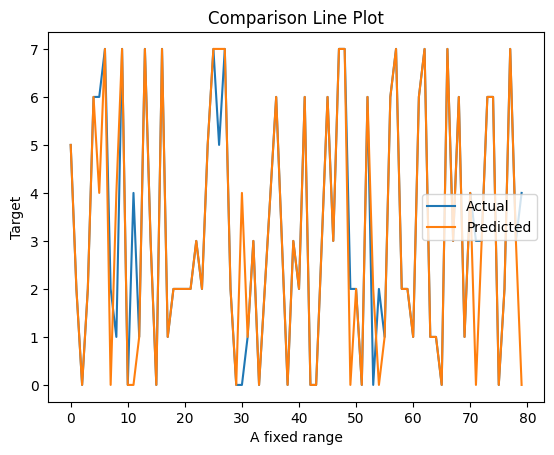

In [20]:
# Plotting the lines
x = np.arange(len(y_test[:80]))
plt.plot(x, y_test[:80], label='Actual')
plt.plot(x, y_pred[:80], label='Predicted')

# Adding labels and title
plt.xlabel('A fixed range')
plt.ylabel('Target')
plt.title('Comparison Line Plot')
plt.legend()
plt.show()

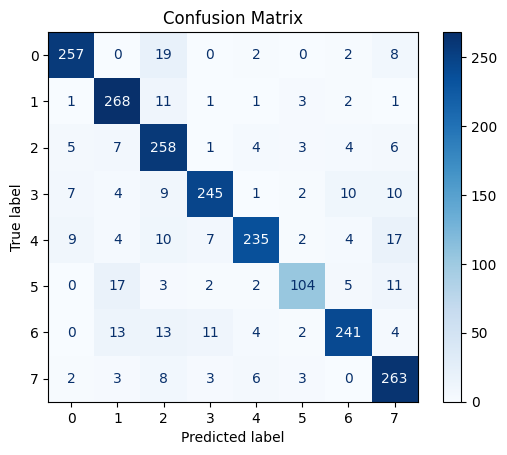

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [23]:
#saving file as .pkl file
import pickle
with open('sound_emotion.pkl', 'wb') as f:  # open a text file
    pickle.dump(model, f) # serialize the list

f.close()

In [24]:
Features.to_csv('features.csv', index=False)